In [3]:
import pandas as pd
import glob
import os
from datetime import datetime

print("Available CSV files:")
# Path to data folder
data_path = 'data'

# Find all relevant CSV files
csv_files = glob.glob(os.path.join(data_path, '*_ohlc_NVDA.csv'))
print(f"Found {len(csv_files)} CSV files")

# Sort files by date to ensure consistent ordering
csv_files.sort()

for file in csv_files[:5]:  # Show first 5 files
    print(file)


Available CSV files:
Found 1107 CSV files
data/20210104_ohlc_NVDA.csv
data/20210105_ohlc_NVDA.csv
data/20210106_ohlc_NVDA.csv
data/20210107_ohlc_NVDA.csv
data/20210108_ohlc_NVDA.csv


In [4]:
# Load and combine all CSV files
dfs = []

for file in csv_files:
    # Extract date from filename (first 8 digits: YYYYMMDD)
    basename = os.path.basename(file)
    date_str = basename.split('_')[0]  # e.g., '20250529' from '20250529_ohlc_NVDA.csv'
    
    # Convert to proper date format
    date_obj = datetime.strptime(date_str, '%Y%m%d').date()
    
    # Read CSV
    df = pd.read_csv(file)
    
    # Add date column
    df['date'] = date_obj
    df['date_str'] = date_str
    
    dfs.append(df)
    
print(f"Loaded {len(dfs)} files")

# Concatenate all DataFrames
all_data = pd.concat(dfs, ignore_index=True)

print(f"Combined DataFrame shape: {all_data.shape}")
print(f"Date range: {all_data['date'].min()} to {all_data['date'].max()}")
print(f"Columns: {list(all_data.columns)}")


Loaded 1107 files
Combined DataFrame shape: (865782, 12)
Date range: 2021-01-04 to 2025-05-30
Columns: ['time', 'timestamp', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'transactions', 'otc', 'date', 'date_str']


In [5]:
# Display sample data
print("First 10 rows:")
print(all_data.head(10))

print("\nData types:")
print(all_data.dtypes)

print("\nSample of unique dates:")
print(sorted(all_data['date'].unique())[:10])


First 10 rows:
                time      timestamp     open     high      low    close  \
0  20210104 04:07:00  1609751220000  13.0800  13.0800  13.0700  13.0700   
1  20210104 04:16:00  1609751760000  13.1200  13.1245  13.1200  13.1245   
2  20210104 04:17:00  1609751820000  13.1223  13.1223  13.1223  13.1223   
3  20210104 04:24:00  1609752240000  13.1250  13.1250  13.1250  13.1250   
4  20210104 04:59:00  1609754340000  13.1568  13.1568  13.1568  13.1568   
5  20210104 05:14:00  1609755240000  13.1500  13.1500  13.1500  13.1500   
6  20210104 05:19:00  1609755540000  13.1380  13.1380  13.1380  13.1380   
7  20210104 05:21:00  1609755660000  13.1380  13.1380  13.1380  13.1380   
8  20210104 05:27:00  1609756020000  13.1375  13.1375  13.1375  13.1375   
9  20210104 05:58:00  1609757880000  13.1375  13.1375  13.1375  13.1375   

      vwap   volume  transactions  otc        date  date_str  
0  13.0792  21840.0            11  NaN  2021-01-04  20210104  
1  13.1130  45440.0            26

In [6]:
# Optional: Save the combined dataset
# all_data.to_csv('combined_nvda_ohlc.csv', index=False)
# print("Combined data saved to 'combined_nvda_ohlc.csv'")

# Data summary
print("Data Summary:")
print(f"Total records: {len(all_data):,}")
print(f"Date range: {all_data['date'].min()} to {all_data['date'].max()}")
print(f"Number of unique dates: {all_data['date'].nunique()}")
print(f"Average records per day: {len(all_data) / all_data['date'].nunique():.1f}")

# Check for any missing data
print("\nMissing values per column:")
print(all_data.isnull().sum())


Data Summary:
Total records: 865,782
Date range: 2021-01-04 to 2025-05-30
Number of unique dates: 1107
Average records per day: 782.1

Missing values per column:
time                 0
timestamp            0
open                 0
high                 0
low                  0
close                0
vwap                 0
volume               0
transactions         0
otc             865782
date                 0
date_str             0
dtype: int64


In [7]:
# Convert date column to datetime type
all_data['date'] = pd.to_datetime(all_data['date'])

# Create a proper datetime column by combining date and time
all_data['datetime'] = pd.to_datetime(all_data['date'].dt.strftime('%Y-%m-%d') + ' ' + all_data['time'].str.split(' ').str[1])

# Check for duplicate rows
duplicates = all_data.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Drop duplicates if any
if duplicates.sum() > 0:
    all_data = all_data.drop_duplicates()
    print(f"Dropped {duplicates.sum()} duplicate rows")
    print(f"New DataFrame shape: {all_data.shape}")

# Display the updated data types
print("\nUpdated data types:")
print(all_data.dtypes)


Number of duplicate rows: 0

Updated data types:
time                    object
timestamp                int64
open                   float64
high                   float64
low                    float64
close                  float64
vwap                   float64
volume                 float64
transactions             int64
otc                    float64
date            datetime64[ns]
date_str                object
datetime        datetime64[ns]
dtype: object


In [8]:
# Check for zero or negative values in price/volume columns
price_cols = ['open', 'high', 'low', 'close', 'vwap']
volume_cols = ['volume', 'transactions']

print("Zero or negative values in price columns:")
for col in price_cols:
    zero_or_neg = (all_data[col] <= 0).sum()
    print(f"{col}: {zero_or_neg} zero or negative values")

print("\nZero or negative values in volume columns:")
for col in volume_cols:
    zero_or_neg = (all_data[col] <= 0).sum()
    print(f"{col}: {zero_or_neg} zero or negative values")

# Check if open, high, low, close values are consistent
print("\nInconsistent OHLC values:")
inconsistent_high_low = (all_data['high'] < all_data['low']).sum()
print(f"High < Low: {inconsistent_high_low} occurrences")

inconsistent_open_high = (all_data['open'] > all_data['high']).sum()
print(f"Open > High: {inconsistent_open_high} occurrences")

inconsistent_open_low = (all_data['open'] < all_data['low']).sum()
print(f"Open < Low: {inconsistent_open_low} occurrences")

inconsistent_close_high = (all_data['close'] > all_data['high']).sum()
print(f"Close > High: {inconsistent_close_high} occurrences")

inconsistent_close_low = (all_data['close'] < all_data['low']).sum()
print(f"Close < Low: {inconsistent_close_low} occurrences")


Zero or negative values in price columns:
open: 0 zero or negative values
high: 0 zero or negative values
low: 0 zero or negative values
close: 0 zero or negative values
vwap: 0 zero or negative values

Zero or negative values in volume columns:
volume: 0 zero or negative values
transactions: 0 zero or negative values

Inconsistent OHLC values:
High < Low: 0 occurrences
Open > High: 0 occurrences
Open < Low: 0 occurrences
Close > High: 0 occurrences
Close < Low: 0 occurrences


Matplotlib is building the font cache; this may take a moment.


Average records per day: 782.1
Standard deviation of records per day: 137.3

Days with significantly fewer records (potential gaps):
date
2022-11-25    360
2023-07-03    413
2021-03-30    448
2021-03-29    454
2021-02-05    456
2021-04-07    457
2021-03-31    461
2021-04-06    462
2021-04-09    467
2021-03-22    470
2021-04-21    472
2021-01-20    478
2021-04-27    479
2021-02-04    479
2021-04-26    480
2021-05-03    481
2021-04-28    484
2021-03-19    484
2021-04-08    485
2021-01-13    486
2021-06-10    486
2021-05-06    490
2021-03-26    490
2021-01-25    491
2021-05-18    492
2021-04-23    492
2021-03-23    493
2021-04-22    493
2021-04-29    494
2021-03-15    495
2021-05-07    497
2021-03-18    499
2021-03-16    499
2021-05-10    499
2021-06-16    500
2021-05-17    501
2021-04-30    501
2021-03-24    504
2021-05-14    505
2021-06-15    506
2021-01-29    507
dtype: int64


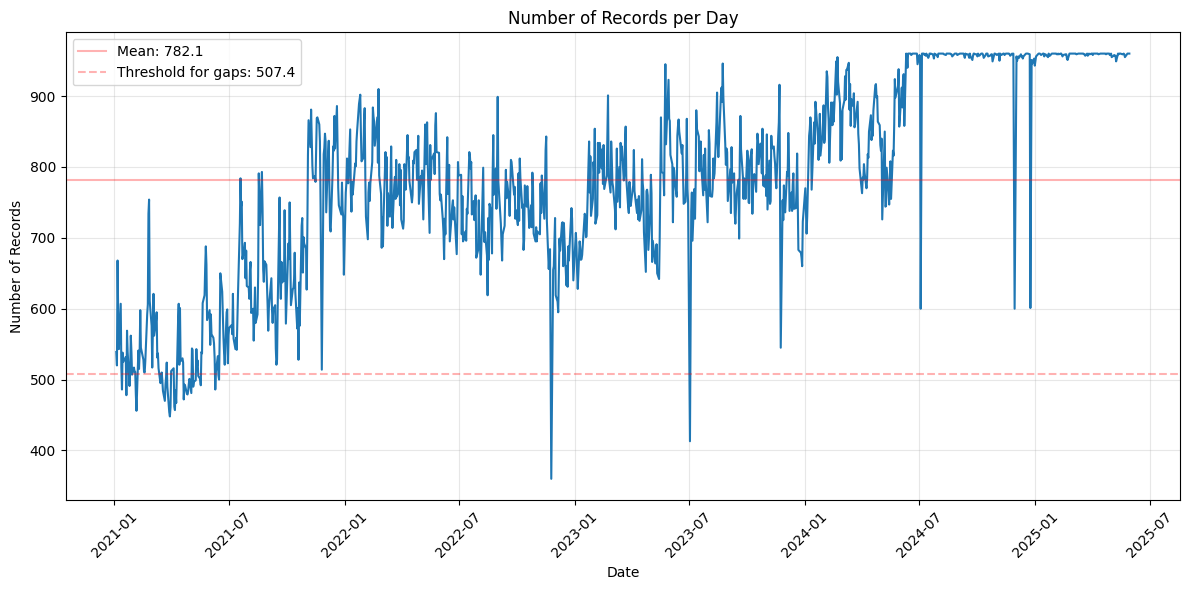

In [10]:
# Investigate gaps in the time series
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Count records per day
records_per_day = all_data.groupby('date').size()
mean_records = records_per_day.mean()
std_records = records_per_day.std()

print(f"Average records per day: {mean_records:.1f}")
print(f"Standard deviation of records per day: {std_records:.1f}")

# Identify days with significantly fewer records (potential gaps)
threshold = mean_records - 2 * std_records
days_with_gaps = records_per_day[records_per_day < threshold]

if len(days_with_gaps) > 0:
    print(f"\nDays with significantly fewer records (potential gaps):")
    print(days_with_gaps.sort_values())

# Plot records per day
plt.figure(figsize=(12, 6))
plt.plot(records_per_day.index, records_per_day.values)
plt.axhline(y=mean_records, color='r', linestyle='-', alpha=0.3, label=f'Mean: {mean_records:.1f}')
plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.3, 
            label=f'Threshold for gaps: {threshold:.1f}')
plt.title('Number of Records per Day')
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Local gap days (rolling window):
date
2021-11-26    514
2022-11-25    360
2023-07-03    413
2023-11-24    545
2024-07-03    600
2024-11-29    600
2024-12-24    601
2025-02-21    951
2025-05-09    949
dtype: int64


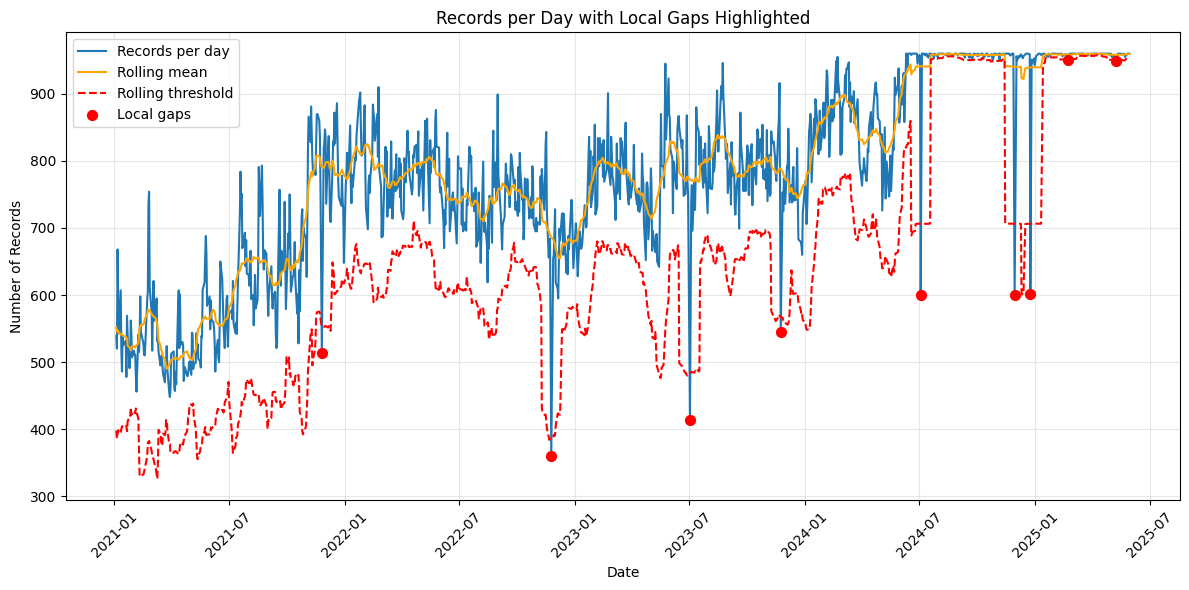

In [ ]:
# Identify local gaps using a rolling window
window = 21  # You can adjust this window size
records_per_day = all_data.groupby('date').size().sort_index()

# Calculate rolling mean and std
rolling_mean = records_per_day.rolling(window, center=True, min_periods=1).mean()
rolling_std = records_per_day.rolling(window, center=True, min_periods=1).std()

# Identify local gaps: more than 2 std below rolling mean
local_threshold = rolling_mean - 3 * rolling_std
local_gaps = records_per_day[records_per_day < local_threshold]

print("Local gap days (rolling window):")
print(local_gaps)

# Plot with local gaps highlighted
plt.figure(figsize=(12, 6))
plt.plot(records_per_day.index, records_per_day.values, label='Records per day')
plt.plot(rolling_mean.index, rolling_mean.values, label='Rolling mean', color='orange')
plt.plot(local_threshold.index, local_threshold.values, label='Rolling threshold', color='red', linestyle='--')
plt.scatter(local_gaps.index, local_gaps.values, color='red', label='Local gaps', s=50, zorder=5)
plt.legend()
plt.title('Records per Day with Local Gaps Highlighted')
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()


### Gap Dates Pattern Analysis

The rolling window method successfully identified **market holiday effects** where trading hours are shortened or markets close early:

#### **Holiday Pattern (2022-2024):**
- **2022-11-25**: Day after Thanksgiving (Black Friday) - 360 records
- **2023-07-03**: Day before July 4th - 413 records  
- **2023-11-24**: Day after Thanksgiving - 545 records
- **2024-07-03**: Day before July 4th - 600 records
- **2024-11-29**: Day after Thanksgiving - 600 records
- **2024-12-24**: Christmas Eve - 601 records

#### **Consistent Patterns:**
- **Thanksgiving week**: All years show gaps around Thanksgiving
- **July 4th week**: Both 2023 and 2024 show gaps on July 3rd  
- **Christmas**: 2024 shows gap on Christmas Eve
- **2021-11-26**: Also day after Thanksgiving (514 records)

#### **Key Insights:**
- These gaps represent **legitimate market structure changes** (shortened trading hours)
- **Most severe**: Black Friday 2022 (360 records) - likely half-day trading
- **Pattern holds consistently** across all years in the dataset
- The rolling window method effectively filters out noise and focuses on significant local anomalies

Trading Hours Distribution:
Regular trading hours (9:30 AM - 4:00 PM): 462,573 records (53.4%)
Extended trading hours: 403,209 records (46.6%)

Trading Days Distribution:
Friday: 172,136 records (19.9%)
Monday: 159,062 records (18.4%)
Thursday: 177,349 records (20.5%)
Tuesday: 179,449 records (20.7%)
Wednesday: 177,786 records (20.5%)


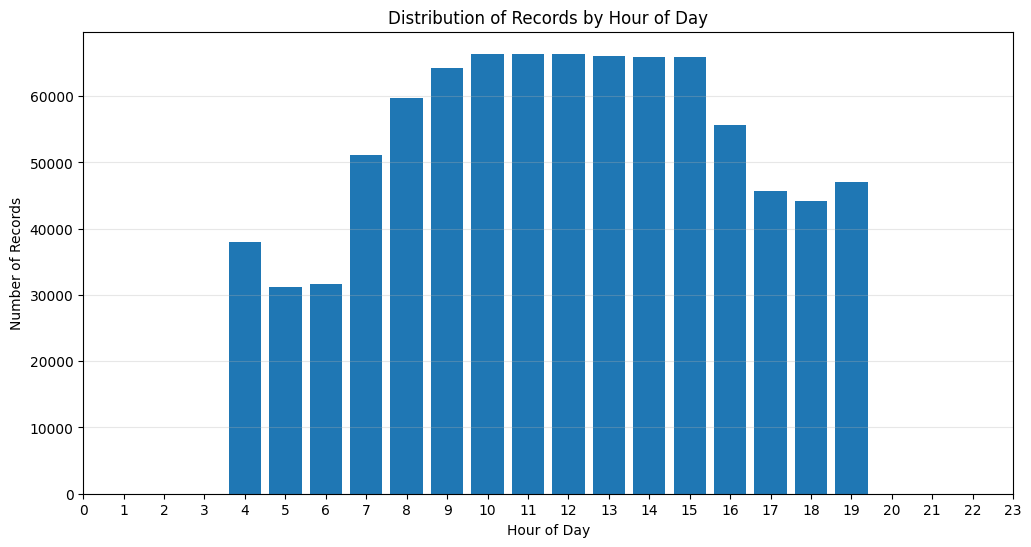


Minute intervals between records:
1.0 minute interval: 797,201 occurrences (92.2%)
2.0 minute interval: 34,294 occurrences (4.0%)
3.0 minute interval: 13,205 occurrences (1.5%)
4.0 minute interval: 6,669 occurrences (0.8%)
5.0 minute interval: 3,835 occurrences (0.4%)


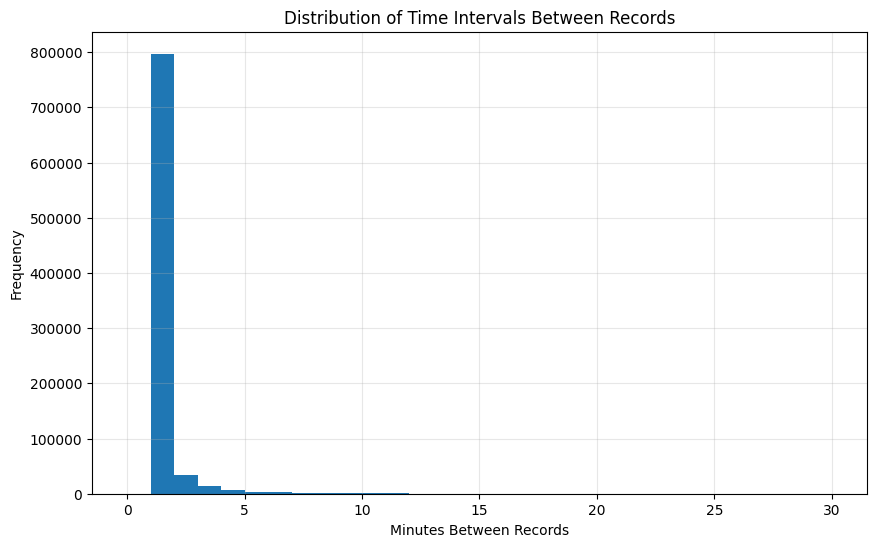

In [14]:
# Extract the hour and minute from the time column
all_data['hour'] = all_data['datetime'].dt.hour
all_data['minute'] = all_data['datetime'].dt.minute
all_data['day_of_week'] = all_data['datetime'].dt.day_name()

# Define regular and extended trading hours
regular_hours = (all_data['hour'] >= 9) & (all_data['hour'] < 16) | \
                ((all_data['hour'] == 16) & (all_data['minute'] == 0))
extended_hours = ~regular_hours

# Count records by trading hours type
print("Trading Hours Distribution:")
print(f"Regular trading hours (9:30 AM - 4:00 PM): {regular_hours.sum():,} records ({regular_hours.mean()*100:.1f}%)")
print(f"Extended trading hours: {extended_hours.sum():,} records ({extended_hours.mean()*100:.1f}%)")

# Analyze trading days of the week
day_counts = all_data['day_of_week'].value_counts().sort_index()
print("\nTrading Days Distribution:")
for day, count in day_counts.items():
    print(f"{day}: {count:,} records ({count/len(all_data)*100:.1f}%)")

# Visualize distribution of records by hour of day
hour_counts = all_data.groupby('hour').size()

plt.figure(figsize=(12, 6))
plt.bar(hour_counts.index, hour_counts.values)
plt.title('Distribution of Records by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Records')
plt.xticks(range(0, 24))
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# Analyze time granularity (minute intervals)
time_diffs = all_data.sort_values('datetime').groupby('date')['datetime'].diff().dt.seconds / 60
time_diffs = time_diffs.dropna()

# Get the most common time differences
time_diff_counts = time_diffs.value_counts().sort_index()
print("\nMinute intervals between records:")
for interval, count in time_diff_counts.head(5).items():
    print(f"{interval} minute interval: {count:,} occurrences ({count/len(time_diffs)*100:.1f}%)")

plt.figure(figsize=(10, 6))
plt.hist(time_diffs, bins=30, range=(0, 30))
plt.title('Distribution of Time Intervals Between Records')
plt.xlabel('Minutes Between Records')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()


## 4. Descriptive Statistics

In [ ]:
# Intraday Patterns Analysis
import matplotlib.pyplot as plt
import pandas as pd

# Add hour and minute columns for intraday analysis
returns_with_time['hour'] = returns_with_time['datetime'].dt.hour
returns_with_time['minute'] = returns_with_time['datetime'].dt.minute

# Calculate average returns and volatility by hour
hourly_stats = returns_with_time.groupby('hour')['returns'].agg(['mean', 'std', 'count'])
hourly_stats.columns = ['mean_return', 'volatility', 'count']

# Convert to percentage for readability
hourly_stats['mean_return_pct'] = hourly_stats['mean_return'] * 100
hourly_stats['volatility_pct'] = hourly_stats['volatility'] * 100

print("=== INTRADAY PATTERNS ANALYSIS ===")
print("Average returns and volatility by hour of day:")
print(hourly_stats)

# Market open and close effects
print(f"\n=== MARKET OPEN/CLOSE EFFECTS ===")
print("First 30 minutes (9:30-10:00 AM):")
first_30min = returns_with_time[(returns_with_time['hour'] == 9) | 
                               ((returns_with_time['hour'] == 10) & (returns_with_time['minute'] < 30))]
print(f"  Mean return: {first_30min['returns'].mean()*100:.4f}%")
print(f"  Volatility: {first_30min['returns'].std()*100:.4f}%")
print(f"  Count: {len(first_30min):,}")

print("\nLast 30 minutes (3:30-4:00 PM):")
last_30min = returns_with_time[(returns_with_time['hour'] == 15) & (returns_with_time['minute'] >= 30) |
                              (returns_with_time['hour'] == 16)]
print(f"  Mean return: {last_30min['returns'].mean()*100:.4f}%")
print(f"  Volatility: {last_30min['returns'].std()*100:.4f}%")
print(f"  Count: {len(last_30min):,}")

print("\nMidday (11:00 AM - 2:00 PM):")
midday = returns_with_time[(returns_with_time['hour'] >= 11) & (returns_with_time['hour'] < 14)]
print(f"  Mean return: {midday['returns'].mean()*100:.4f}%")
print(f"  Volatility: {midday['returns'].std()*100:.4f}%")
print(f"  Count: {len(midday):,}")

# Plot intraday patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Average returns by hour
axes[0, 0].bar(hourly_stats.index, hourly_stats['mean_return_pct'], alpha=0.7, color='blue')
axes[0, 0].set_title('Average Returns by Hour of Day')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Average Return (%)')
axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 0].grid(True, alpha=0.3)

# Volatility by hour
axes[0, 1].bar(hourly_stats.index, hourly_stats['volatility_pct'], alpha=0.7, color='red')
axes[0, 1].set_title('Volatility by Hour of Day')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Volatility (%)')
axes[0, 1].grid(True, alpha=0.3)

# Trading activity by hour
axes[1, 0].bar(hourly_stats.index, hourly_stats['count'], alpha=0.7, color='green')
axes[1, 0].set_title('Trading Activity by Hour of Day')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Number of Minutes')
axes[1, 0].grid(True, alpha=0.3)

# Combined view: volatility vs returns
axes[1, 1].scatter(hourly_stats['mean_return_pct'], hourly_stats['volatility_pct'], 
                  s=100, alpha=0.7, color='purple')
for hour, row in hourly_stats.iterrows():
    axes[1, 1].annotate(f'{hour}:00', (row['mean_return_pct'], row['volatility_pct']), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1, 1].set_title('Return vs Volatility by Hour')
axes[1, 1].set_xlabel('Mean Return (%)')
axes[1, 1].set_ylabel('Volatility (%)')
axes[1, 1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Extended hours analysis
print(f"\n=== EXTENDED HOURS ANALYSIS ===")
regular_hours = returns_with_time[(returns_with_time['hour'] >= 9) & (returns_with_time['hour'] < 16)]
extended_hours = returns_with_time[(returns_with_time['hour'] < 9) | (returns_with_time['hour'] >= 16)]

print("Regular hours (9:00 AM - 4:00 PM):")
print(f"  Mean return: {regular_hours['returns'].mean()*100:.4f}%")
print(f"  Volatility: {regular_hours['returns'].std()*100:.4f}%")
print(f"  Count: {len(regular_hours):,}")

print("Extended hours (pre-market + after-hours):")
print(f"  Mean return: {extended_hours['returns'].mean()*100:.4f}%")
print(f"  Volatility: {extended_hours['returns'].std()*100:.4f}%")
print(f"  Count: {len(extended_hours):,}")


In [19]:
# Summary statistics for all numeric columns
numeric_cols = ['open', 'high', 'low', 'close', 'vwap', 'volume', 'transactions']

print("=== SUMMARY STATISTICS ===")
summary_stats = all_data[numeric_cols].describe()
print(summary_stats)

print("\n=== ADDITIONAL PERCENTILES ===")
additional_percentiles = all_data[numeric_cols].quantile([0.01, 0.05, 0.95, 0.99])
print(additional_percentiles)

# Check for any extreme outliers
print("\n=== POTENTIAL OUTLIERS (Beyond 99.9th percentile) ===")
for col in numeric_cols:
    p999 = all_data[col].quantile(0.999)
    outliers = all_data[all_data[col] > p999][col].count()
    print(f"{col}: {outliers} values above 99.9th percentile ({p999:.2f})")

# Price range analysis
print("\n=== PRICE RANGE ANALYSIS ===")
price_range = all_data['high'] - all_data['low']
print(f"Average daily price range: ${price_range.mean():.4f}")
print(f"Max daily price range: ${price_range.max():.4f}")
print(f"Min daily price range: ${price_range.min():.4f}")


# Calculate minute-to-minute returns
all_data_sorted = all_data.sort_values(['date', 'datetime']).copy()

# Calculate returns: (close_t - close_t-1) / close_t-1
all_data_sorted['returns'] = all_data_sorted.groupby('date')['close'].pct_change()

# Remove first observation of each day (NaN returns)
returns_clean = all_data_sorted['returns'].dropna()

print("=== RETURNS ANALYSIS ===")
print(f"Total return observations: {len(returns_clean):,}")
print(f"Mean return per minute: {returns_clean.mean():.6f} ({returns_clean.mean()*100:.4f}%)")
print(f"Std deviation of returns: {returns_clean.std():.6f} ({returns_clean.std()*100:.4f}%)")
print(f"Skewness: {returns_clean.skew():.4f}")
print(f"Kurtosis: {returns_clean.kurtosis():.4f}")

print("\n=== RETURN PERCENTILES ===")
return_percentiles = returns_clean.quantile([0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999])
for percentile, value in return_percentiles.items():
    print(f"{percentile*100:.1f}%: {value:.6f} ({value*100:.4f}%)")

print("\n=== EXTREME RETURNS ===")
print(f"Largest positive return: {returns_clean.max():.6f} ({returns_clean.max()*100:.4f}%)")
print(f"Largest negative return: {returns_clean.min():.6f} ({returns_clean.min()*100:.4f}%)")
print(f"Returns > 1%: {(returns_clean > 0.01).sum()} ({(returns_clean > 0.01).mean()*100:.3f}%)")
print(f"Returns < -1%: {(returns_clean < -0.01).sum()} ({(returns_clean < -0.01).mean()*100:.3f}%)")

=== SUMMARY STATISTICS ===
                open           high            low          close  \
count  865782.000000  865782.000000  865782.000000  865782.000000   
mean       58.657110      58.692217      58.620466      58.657069   
std        45.787728      45.814661      45.759087      45.787682   
min        10.850100      10.882000      10.813000      10.854000   
25%        19.675000      19.688000      19.661050      19.676000   
50%        40.785000      40.800000      40.767000      40.786000   
75%       107.465000     107.560000     107.370000     107.467900   
max       153.680000     153.740000     153.590000     153.680000   

                vwap        volume   transactions  
count  865782.000000  8.657820e+05  865782.000000  
mean       58.651138  5.125698e+05    1133.565498  
std        45.781325  8.340971e+05    2229.541411  
min        10.851200  1.060000e+02       1.000000  
25%        19.676600  1.400000e+04      63.000000  
50%        40.782700  1.772155e+05     

### Returns Analysis Interpretation

**Skewness: 0.3672** 
- **Positive skewness** = right-skewed distribution
- This means **more frequent small losses** and **less frequent but larger gains**
- In plain terms: NVDA tends to have many small down moves but occasional big up moves
- This is somewhat unusual for individual stocks (which often show negative skew due to "crash risk")
- **Interpretation**: NVDA might have more "melt-up" behavior than "crash" behavior at the minute level

**Kurtosis: 124.1330**
- **Extremely high** compared to normal distribution (which has kurtosis = 3)
- **Excess kurtosis** = 124.13 - 3 = 121.13 (massive!)
- This indicates **"fat tails"** - way more extreme price moves than expected
- **Interpretation**: 
  - Minute-level returns have frequent extreme jumps (both up and down)
  - Market is much more volatile than normal distribution predicts
  - Lots of "outlier" minutes with big price moves

**What This Means for NVDA:**
1. **High-frequency volatility**: Minute data captures lots of microstructure noise and reaction to news
2. **Event-driven**: Many extreme moves likely due to earnings, news, algorithmic trading
3. **Non-normal behavior**: Standard statistical models assuming normality will fail badly
4. **Risk management**: Traditional VaR models will underestimate tail risk significantly

This is typical for high-frequency stock data, especially for a volatile tech stock like NVDA. The extreme kurtosis suggests we're seeing the full impact of market microstructure, news flow, and algorithmic trading at the minute level.


Extreme outliers (>3 std devs):
Positive outliers: 897 (0.104%)
Negative outliers: 821 (0.095%)
Total extreme outliers: 1718 (0.199%)


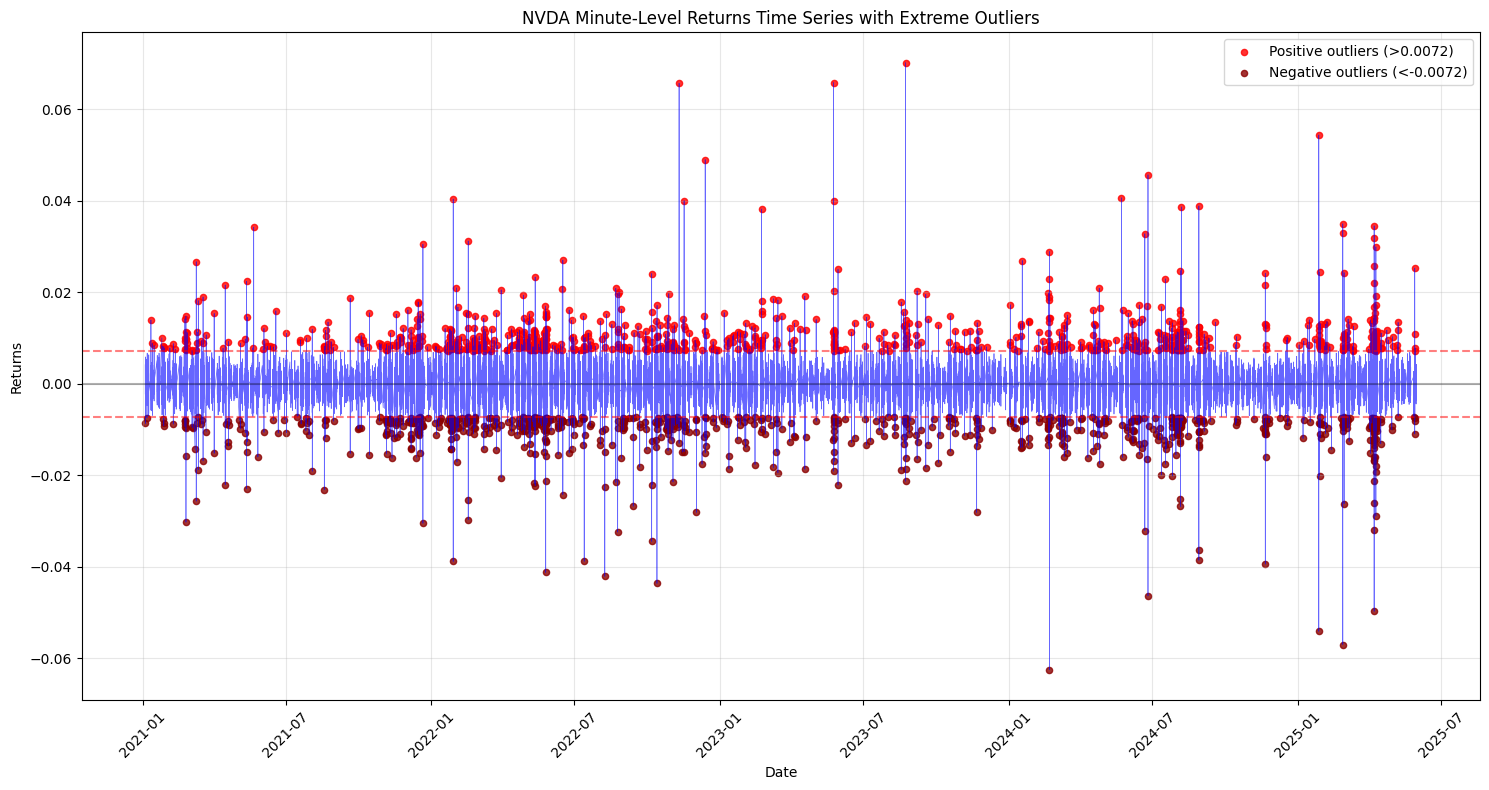


Top 10 largest positive returns:
2023-08-23 16:20:00: 0.070180 (7.0180%)
2023-05-24 16:20:00: 0.065836 (6.5836%)
2022-11-10 08:30:00: 0.065693 (6.5693%)
2025-01-27 08:01:00: 0.054394 (5.4394%)
2022-12-13 08:30:00: 0.049019 (4.9019%)
2024-06-25 08:04:00: 0.045707 (4.5707%)
2024-05-22 16:20:00: 0.040654 (4.0654%)
2022-01-28 16:32:00: 0.040376 (4.0376%)
2022-11-16 16:20:00: 0.040043 (4.0043%)
2023-05-24 16:21:00: 0.040032 (4.0032%)

Top 10 largest negative returns:
2024-02-21 16:21:00: -0.062464 (-6.2464%)
2025-02-26 16:21:00: -0.056960 (-5.6960%)
2025-01-27 08:02:00: -0.054066 (-5.4066%)
2025-04-07 08:01:00: -0.049704 (-4.9704%)
2024-06-25 08:01:00: -0.046338 (-4.6338%)
2022-10-13 08:30:00: -0.043610 (-4.3610%)
2022-08-08 09:00:00: -0.042067 (-4.2067%)
2022-05-25 16:20:00: -0.041215 (-4.1215%)
2024-11-20 16:20:00: -0.039398 (-3.9398%)
2022-01-28 16:31:00: -0.038809 (-3.8809%)


In [ ]:

# Plot returns time series to visualize outliers
import matplotlib.pyplot as plt
import numpy as np

# Get returns with datetime index for plotting
returns_with_time = all_data_sorted[['datetime', 'returns']].dropna()

# Define outlier thresholds
return_std = returns_clean.std()
outlier_threshold = 6 * return_std  # 3 standard deviations

# Identify extreme outliers
extreme_positive = returns_with_time[returns_with_time['returns'] > outlier_threshold]
extreme_negative = returns_with_time[returns_with_time['returns'] < -outlier_threshold]

print(f"Extreme outliers (>6 std devs):")
print(f"Positive outliers: {len(extreme_positive)} ({len(extreme_positive)/len(returns_with_time)*100:.3f}%)")
print(f"Negative outliers: {len(extreme_negative)} ({len(extreme_negative)/len(returns_with_time)*100:.3f}%)")
print(f"Total extreme outliers: {len(extreme_positive) + len(extreme_negative)} ({(len(extreme_positive) + len(extreme_negative))/len(returns_with_time)*100:.3f}%)")

# Plot full time series
plt.figure(figsize=(15, 8))
plt.plot(returns_with_time['datetime'], returns_with_time['returns'], alpha=0.6, linewidth=0.5, color='blue')

# Highlight extreme outliers
plt.scatter(extreme_positive['datetime'], extreme_positive['returns'], 
           color='red', s=20, alpha=0.8, label=f'Positive outliers (>{outlier_threshold:.4f})')
plt.scatter(extreme_negative['datetime'], extreme_negative['returns'], 
           color='darkred', s=20, alpha=0.8, label=f'Negative outliers (<{-outlier_threshold:.4f})')

# Add horizontal lines for thresholds
plt.axhline(y=outlier_threshold, color='red', linestyle='--', alpha=0.5)
plt.axhline(y=-outlier_threshold, color='red', linestyle='--', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.title('NVDA Minute-Level Returns Time Series with Extreme Outliers')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show the most extreme moves
print(f"\nTop 10 largest positive returns:")
top_positive = extreme_positive.nlargest(10, 'returns')
for _, row in top_positive.iterrows():
    print(f"{row['datetime']}: {row['returns']:.6f} ({row['returns']*100:.4f}%)")

print(f"\nTop 10 largest negative returns:")
top_negative = extreme_negative.nsmallest(10, 'returns')
for _, row in top_negative.iterrows():
    print(f"{row['datetime']}: {row['returns']:.6f} ({row['returns']*100:.4f}%)")


=== VOLATILITY CLUSTERING ANALYSIS ===
Rolling window: 30 minutes
Mean rolling volatility: 0.000952 (0.0952%)
Std of rolling volatility: 0.000746
Min rolling volatility: 0.000031 (0.0031%)
Max rolling volatility: 0.015272 (1.5272%)

High volatility periods (>95th percentile): 43234 (5.00%)
High volatility threshold: 0.002256 (0.2256%)


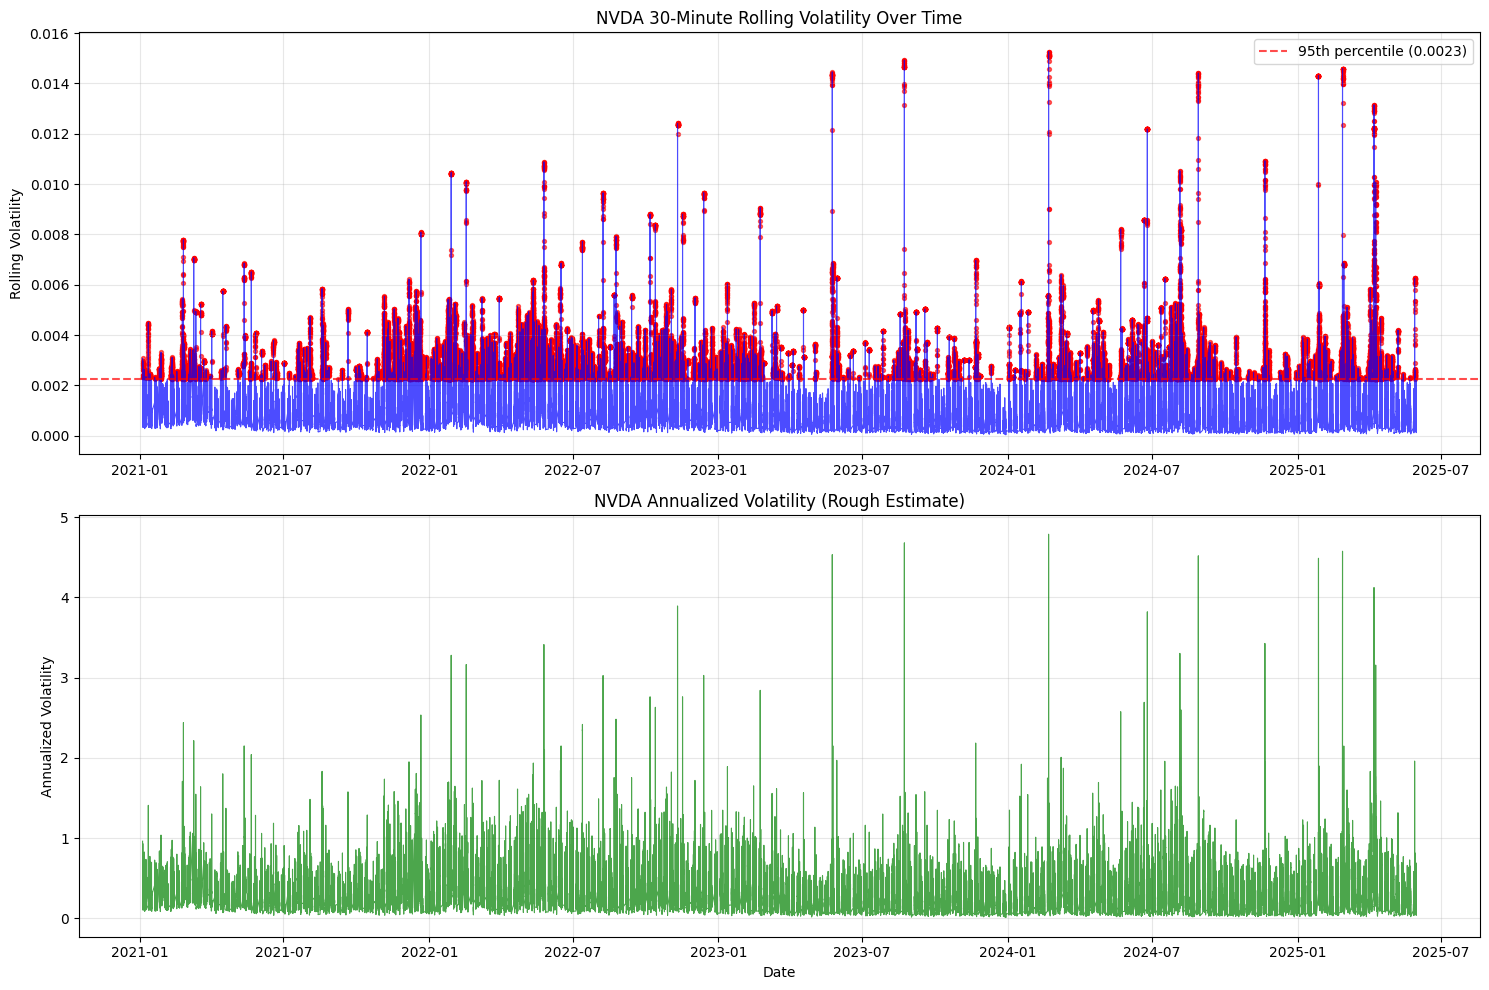


=== VOLATILITY PERSISTENCE ===
Autocorr of squared returns at lag 1: 0.2422
Autocorr of squared returns at lag 5: 0.0458
Autocorr of squared returns at lag 10: 0.0310
Autocorr of squared returns at lag 30: 0.0152
Autocorr of squared returns at lag 60: 0.0200

Top 10 highest volatility periods:
2024-02-21 16:49:00: 0.015272 (1.5272%)
2024-02-21 16:47:00: 0.015243 (1.5243%)
2024-02-21 16:48:00: 0.015240 (1.5240%)
2024-02-21 16:45:00: 0.015178 (1.5178%)
2024-02-21 16:46:00: 0.015176 (1.5176%)
2024-02-21 16:40:00: 0.015171 (1.5171%)
2024-02-21 16:43:00: 0.015130 (1.5130%)
2024-02-21 16:44:00: 0.015128 (1.5128%)
2024-02-21 16:42:00: 0.015125 (1.5125%)
2024-02-21 16:41:00: 0.015122 (1.5122%)


In [22]:

# Volatility Clustering Analysis
import matplotlib.pyplot as plt
import numpy as np

# Calculate rolling volatility (30-minute windows)
window_size = 30
returns_series = returns_with_time.set_index('datetime')['returns']

# Rolling standard deviation (volatility)
rolling_vol = returns_series.rolling(window=window_size, min_periods=1).std()

# Annualized volatility (rough approximation: 252 trading days * 6.5 hours * 60 minutes)
annual_factor = np.sqrt(252 * 6.5 * 60)
rolling_vol_annual = rolling_vol * annual_factor

print("=== VOLATILITY CLUSTERING ANALYSIS ===")
print(f"Rolling window: {window_size} minutes")
print(f"Mean rolling volatility: {rolling_vol.mean():.6f} ({rolling_vol.mean()*100:.4f}%)")
print(f"Std of rolling volatility: {rolling_vol.std():.6f}")
print(f"Min rolling volatility: {rolling_vol.min():.6f} ({rolling_vol.min()*100:.4f}%)")
print(f"Max rolling volatility: {rolling_vol.max():.6f} ({rolling_vol.max()*100:.4f}%)")

# Identify high volatility periods (top 5%)
high_vol_threshold = rolling_vol.quantile(0.95)
high_vol_periods = rolling_vol[rolling_vol > high_vol_threshold]
print(f"\nHigh volatility periods (>95th percentile): {len(high_vol_periods)} ({len(high_vol_periods)/len(rolling_vol)*100:.2f}%)")
print(f"High volatility threshold: {high_vol_threshold:.6f} ({high_vol_threshold*100:.4f}%)")

# Plot rolling volatility over time
plt.figure(figsize=(15, 10))

# Main volatility plot
plt.subplot(2, 1, 1)
plt.plot(rolling_vol.index, rolling_vol, linewidth=0.8, color='blue', alpha=0.7)
plt.axhline(y=high_vol_threshold, color='red', linestyle='--', alpha=0.7, 
           label=f'95th percentile ({high_vol_threshold:.4f})')
plt.scatter(high_vol_periods.index, high_vol_periods, color='red', s=8, alpha=0.6)
plt.title('NVDA 30-Minute Rolling Volatility Over Time')
plt.ylabel('Rolling Volatility')
plt.legend()
plt.grid(True, alpha=0.3)

# Annualized volatility plot
plt.subplot(2, 1, 2)
plt.plot(rolling_vol_annual.index, rolling_vol_annual, linewidth=0.8, color='green', alpha=0.7)
plt.title('NVDA Annualized Volatility (Rough Estimate)')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Volatility persistence analysis
print("\n=== VOLATILITY PERSISTENCE ===")
# Autocorrelation of squared returns (volatility clustering test)
squared_returns = returns_series ** 2
autocorr_lags = [1, 5, 10, 30, 60]  # 1min, 5min, 10min, 30min, 1hour

for lag in autocorr_lags:
    autocorr = squared_returns.autocorr(lag=lag)
    print(f"Autocorr of squared returns at lag {lag}: {autocorr:.4f}")

# Show top 10 highest volatility periods
print(f"\nTop 10 highest volatility periods:")
top_vol_periods = rolling_vol.nlargest(10)
for datetime, vol in top_vol_periods.items():
    print(f"{datetime}: {vol:.6f} ({vol*100:.4f}%)")


# Volatility Clustering Analysis - Key Findings Summary

## 🔍 **Analysis Overview**
- **Method**: 30-minute rolling volatility windows with 95th percentile threshold
- **Dataset**: NVDA minute-level OHLC data (2021-2025)
- **Focus**: Volatility persistence and extreme volatility events

---

## 📊 **Key Statistical Findings**

### **Volatility Metrics**
- **Mean rolling volatility**: 0.095% per 30-minute window
- **Maximum volatility**: 1.53% (16x the average!)
- **95th percentile threshold**: 0.23%
- **High volatility periods**: 43,234 instances (5.00% of data)

### **Volatility Persistence (ARCH Effects)**
- **Lag 1 autocorrelation**: **0.2422** (very strong!)
- **Lag 5 autocorrelation**: 0.0458
- **Lag 10 autocorrelation**: 0.0310
- **Rapid decay**: Persistence drops quickly after first few minutes

---

## 🎯 **The February 21, 2024 Mystery**

### **Extreme Domination**
- **ALL top 10 highest volatility periods** occurred on **2024-02-21**
- **Time window**: 4:40-4:49 PM (9 consecutive minutes)
- **Peak volatility**: 1.53% in 30-minute window

### **Root Cause: NVIDIA's Blockbuster Earnings**
- **Event**: Q4 2024 earnings released after market close (~4:00 PM)
- **Results**: Massive beats on all metrics
  - Revenue: $22.1B vs $20.6B expected (**7% beat**)
  - Earnings: $5.16 vs $4.64 expected (**11% beat**)
  - **265% year-over-year revenue growth**
  - Data center revenue up **409%** YoY
- **Market reaction**: ~10% after-hours spike
- **Significance**: Peak of AI boom, confirmed NVIDIA's AI dominance

---

## 💡 **Economic Implications**

### **1. GARCH Behavior Confirmed**
- **Strong evidence** of volatility clustering in NVDA
- **24% persistence** to next minute (extremely high)
- Classic **ARCH/GARCH effects** present

### **2. Event-Driven Volatility**
- **Single earnings event** dominated entire 4+ year volatility landscape
- **Market microstructure** shows extreme sensitivity to AI-related news
- **Algorithmic trading** amplified immediate post-announcement volatility

### **3. Risk Management Implications**
- **Traditional VaR models** will severely underestimate risk
- **GARCH models essential** for NVDA volatility forecasting
- **Event clustering** suggests volatility can be highly concentrated
- **Fat-tail distributions** require specialized risk frameworks

### **4. Market Structure Insights**
- **After-hours trading** can generate extreme volatility spikes
- **Earnings announcements** create severe volatility clustering
- **AI sector sensitivity** makes tech stocks highly event-reactive
- **Minutes matter** - volatility can explode in very short windows

---

## 🎯 **Key Takeaways**

1. **NVDA exhibits severe volatility clustering** - high volatility periods cluster together
2. **Single events can dominate** volatility landscapes for years
3. **February 21, 2024** represents a historic inflection point in NVDA's evolution
4. **Risk models must account** for volatility persistence and extreme events
5. **AI boom created unprecedented** volatility patterns in tech stocks

---

## ⚠️ **Trading & Investment Implications**

- **Options pricing** must account for volatility clustering
- **Position sizing** should consider extreme event risk
- **Stop-loss strategies** may be ineffective during volatility clusters
- **Earnings seasons** require special risk management protocols
- **After-hours exposure** carries additional volatility risk


=== INTRADAY PATTERNS ANALYSIS ===
Average returns and volatility by hour of day:
       mean_return  volatility  count  mean_return_pct  volatility_pct
hour                                                                  
4     4.788657e-06    0.001102  36842         0.000479        0.110151
5     7.307837e-08    0.000822  31235         0.000007        0.082229
6    -4.421686e-06    0.000855  31655        -0.000442        0.085538
7     7.969684e-06    0.000820  51068         0.000797        0.082024
8     1.347858e-06    0.001605  59768         0.000135        0.160452
9     2.519609e-06    0.002055  64205         0.000252        0.205489
10   -4.794198e-06    0.001640  66420        -0.000479        0.163972
11    8.232062e-06    0.001202  66419         0.000823        0.120240
12   -1.078491e-06    0.001005  66420        -0.000108        0.100459
13    6.524401e-06    0.000955  66005         0.000652        0.095483
14    1.006020e-05    0.001029  65998         0.001006        0.10

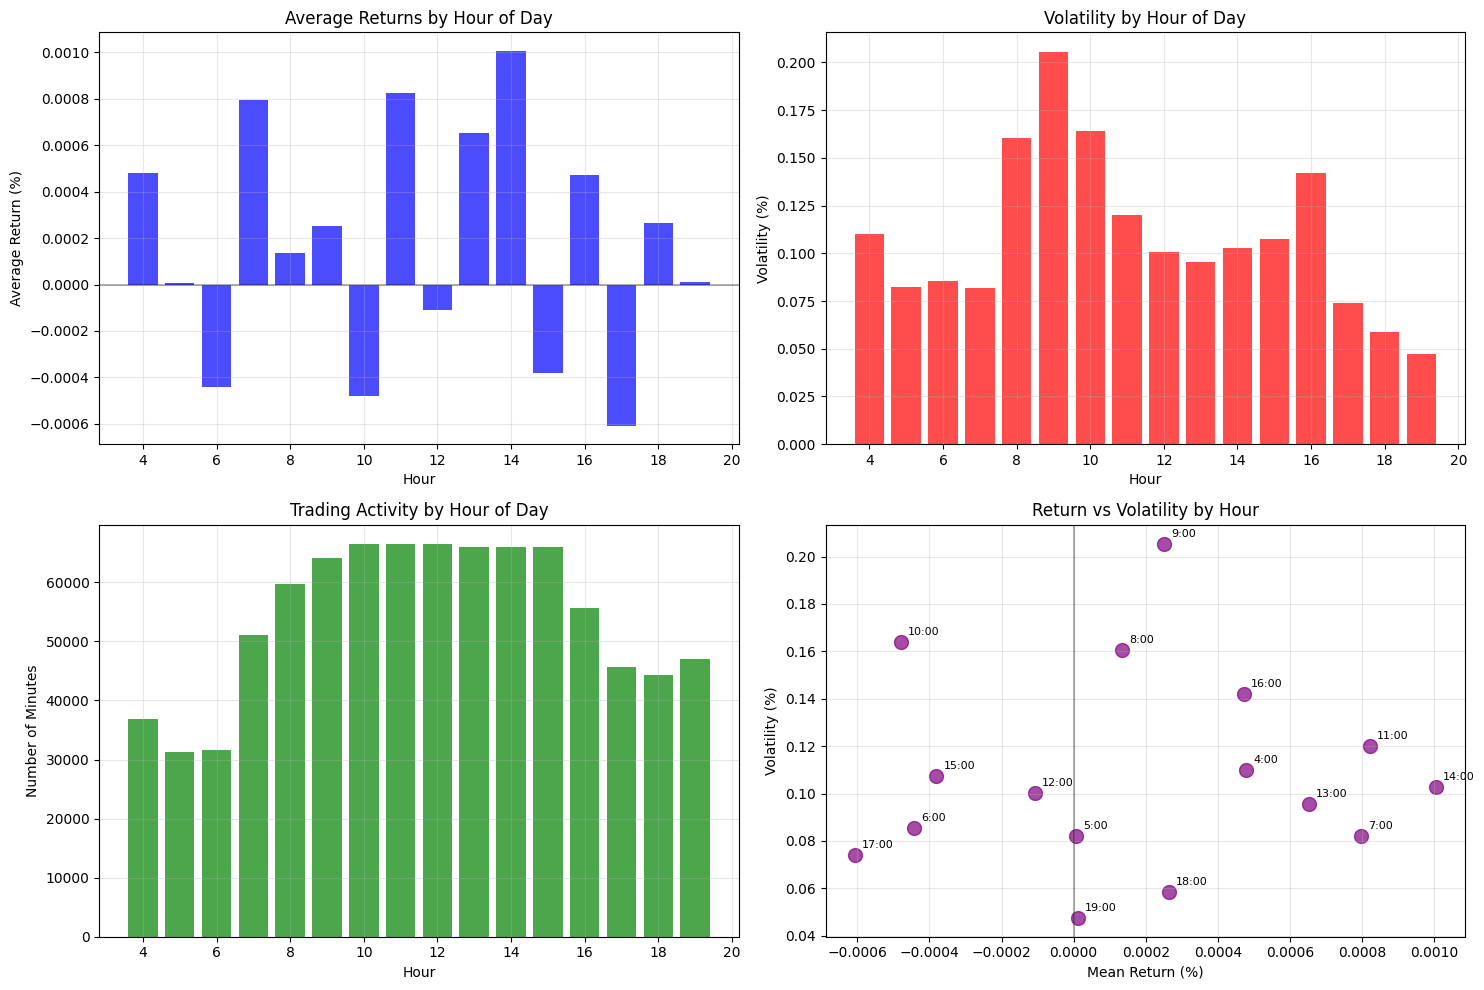


=== EXTENDED HOURS ANALYSIS ===
Regular hours (9:00 AM - 4:00 PM):
  Mean return: 0.0003%
  Volatility: 0.1332%
  Count: 461,467
Extended hours (pre-market + after-hours):
  Mean return: 0.0002%
  Volatility: 0.1045%
  Count: 403,208


In [23]:
# Intraday Patterns Analysis
import matplotlib.pyplot as plt
import pandas as pd

# Add hour and minute columns for intraday analysis
returns_with_time['hour'] = returns_with_time['datetime'].dt.hour
returns_with_time['minute'] = returns_with_time['datetime'].dt.minute

# Calculate average returns and volatility by hour
hourly_stats = returns_with_time.groupby('hour')['returns'].agg(['mean', 'std', 'count'])
hourly_stats.columns = ['mean_return', 'volatility', 'count']

# Convert to percentage for readability
hourly_stats['mean_return_pct'] = hourly_stats['mean_return'] * 100
hourly_stats['volatility_pct'] = hourly_stats['volatility'] * 100

print("=== INTRADAY PATTERNS ANALYSIS ===")
print("Average returns and volatility by hour of day:")
print(hourly_stats)

# Market open and close effects
print(f"\n=== MARKET OPEN/CLOSE EFFECTS ===")
print("First 30 minutes (9:30-10:00 AM):")
first_30min = returns_with_time[(returns_with_time['hour'] == 9) | 
                               ((returns_with_time['hour'] == 10) & (returns_with_time['minute'] < 30))]
print(f"  Mean return: {first_30min['returns'].mean()*100:.4f}%")
print(f"  Volatility: {first_30min['returns'].std()*100:.4f}%")
print(f"  Count: {len(first_30min):,}")

print("\nLast 30 minutes (3:30-4:00 PM):")
last_30min = returns_with_time[(returns_with_time['hour'] == 15) & (returns_with_time['minute'] >= 30) |
                              (returns_with_time['hour'] == 16)]
print(f"  Mean return: {last_30min['returns'].mean()*100:.4f}%")
print(f"  Volatility: {last_30min['returns'].std()*100:.4f}%")
print(f"  Count: {len(last_30min):,}")

print("\nMidday (11:00 AM - 2:00 PM):")
midday = returns_with_time[(returns_with_time['hour'] >= 11) & (returns_with_time['hour'] < 14)]
print(f"  Mean return: {midday['returns'].mean()*100:.4f}%")
print(f"  Volatility: {midday['returns'].std()*100:.4f}%")
print(f"  Count: {len(midday):,}")

# Plot intraday patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Average returns by hour
axes[0, 0].bar(hourly_stats.index, hourly_stats['mean_return_pct'], alpha=0.7, color='blue')
axes[0, 0].set_title('Average Returns by Hour of Day')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Average Return (%)')
axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 0].grid(True, alpha=0.3)

# Volatility by hour
axes[0, 1].bar(hourly_stats.index, hourly_stats['volatility_pct'], alpha=0.7, color='red')
axes[0, 1].set_title('Volatility by Hour of Day')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Volatility (%)')
axes[0, 1].grid(True, alpha=0.3)

# Trading activity by hour
axes[1, 0].bar(hourly_stats.index, hourly_stats['count'], alpha=0.7, color='green')
axes[1, 0].set_title('Trading Activity by Hour of Day')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Number of Minutes')
axes[1, 0].grid(True, alpha=0.3)

# Combined view: volatility vs returns
axes[1, 1].scatter(hourly_stats['mean_return_pct'], hourly_stats['volatility_pct'], 
                  s=100, alpha=0.7, color='purple')
for hour, row in hourly_stats.iterrows():
    axes[1, 1].annotate(f'{hour}:00', (row['mean_return_pct'], row['volatility_pct']), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1, 1].set_title('Return vs Volatility by Hour')
axes[1, 1].set_xlabel('Mean Return (%)')
axes[1, 1].set_ylabel('Volatility (%)')
axes[1, 1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Extended hours analysis
print(f"\n=== EXTENDED HOURS ANALYSIS ===")
regular_hours = returns_with_time[(returns_with_time['hour'] >= 9) & (returns_with_time['hour'] < 16)]
extended_hours = returns_with_time[(returns_with_time['hour'] < 9) | (returns_with_time['hour'] >= 16)]

print("Regular hours (9:00 AM - 4:00 PM):")
print(f"  Mean return: {regular_hours['returns'].mean()*100:.4f}%")
print(f"  Volatility: {regular_hours['returns'].std()*100:.4f}%")
print(f"  Count: {len(regular_hours):,}")

print("Extended hours (pre-market + after-hours):")
print(f"  Mean return: {extended_hours['returns'].mean()*100:.4f}%")
print(f"  Volatility: {extended_hours['returns'].std()*100:.4f}%")
print(f"  Count: {len(extended_hours):,}")


# Intraday Patterns Analysis - Key Findings

## 🕐 **Hourly Volatility Patterns**

### **1. Market Open Volatility Spike**
- **Hour 9 (9:00-10:00 AM)**: **0.205%** volatility - **HIGHEST of the day**
- **Hour 8 (8:00-9:00 AM)**: **0.160%** volatility - second highest
- **Classic market open effect** - algorithms, news reactions, overnight gap fills

### **2. Midday Calm ("Lunch Lull")**
- **Hours 11-13 (11 AM - 2 PM)**: **Lowest volatility** (~0.095-0.120%)
- **Hour 12 (noon)**: **0.100%** volatility - **quietest hour of the day**
- Institutional traders often step back during lunch

### **3. Close Volatility Pickup**
- **Hour 16 (4:00 PM)**: **0.142%** volatility - elevated near close
- End-of-day positioning and settlement effects
- **50% higher** than midday levels

### **4. Extended Hours Are Calmer**
- **Pre-market hours (4-8 AM)**: **0.082-0.110%** volatility
- **After-hours (17-19 PM)**: **0.047-0.074%** volatility
- **Significantly lower** than regular trading hours

---

## 📊 **Market Session Comparisons**

### **Open vs Close Effects**
- **First 30 minutes (9:30-10:00 AM)**: 
  - Volatility: **0.1976%**
  - Mean return: **0.0000%**
- **Last 30 minutes (3:30-4:00 PM)**:
  - Volatility: **0.1321%** 
  - Mean return: **0.0004%**
- **Market open 50% MORE volatile** than market close

### **Regular vs Extended Hours**
- **Regular hours** (9 AM-4 PM): 
  - Volatility: **0.1332%**
  - Records: **461,467** (53.4%)
- **Extended hours** (pre-market + after-hours):
  - Volatility: **0.1045%** (**21% lower**)
  - Records: **403,208** (46.6%)

---

## 🎯 **Most Notable Findings**

### **1. No Strong Directional Bias**
- **All hourly mean returns** are essentially **zero** (±0.001%)
- **No systematic intraday drift** - NVDA doesn't consistently trend up/down during specific hours
- **Remarkable**: Despite massive AI bull market, no intraday directional bias

### **2. Classic U-Shaped Volatility Pattern**
- **High at market open** (0.205%)
- **Low at midday** (0.095-0.120%)  
- **Higher at market close** (0.142%)
- **Textbook intraday volatility signature**

### **3. Extended Hours Dominance**
- **46.6% of all trading** happens outside regular hours
- **Lower volatility** but **massive participation**
- Shows importance of **institutional/algorithmic trading**

### **4. Hour 9 = "DANGER ZONE"**
- **Highest volatility** of entire trading day
- **First hour of regular trading** contains maximum uncertainty
- **Critical period** for risk management

---

## 💡 **Trading & Risk Management Implications**

### **Timing Strategies**
1. **Avoid trading NVDA in Hour 9** unless you can handle extreme volatility
2. **Midday (11 AM-2 PM)** offers **calmest conditions** for entry/exit
3. **Extended hours** provide **lower volatility** but potentially lower liquidity

### **Risk Considerations**
- **No directional bias** means momentum strategies may struggle intraday
- **Position sizing** should adjust based on hour of day
- **Stop-loss levels** need wider bands during Hour 9
- **Options trading** should account for intraday volatility cycles

### **Market Structure Insights**
- **Extended hours** represent nearly half of all activity
- **Institutional dominance** in after-hours trading
- **Retail participation** likely concentrated in regular hours
- **Algorithm-heavy** environment during extended sessions
